In [1]:
import torch
from torch_geometric.data import DataLoader,Dataset,Data
import pandas as pd
import numpy as np
import gc
import torch.nn.functional as F
from tqdm import tqdm, trange


train_L = torch.load('./dataset/converted/train.pt',map_location='cpu')
val_L = torch.load('./dataset/converted/val.pt',map_location='cpu')
test_L  = torch.load('./dataset/converted/test.pt',map_location='cpu')
batch_size = 128
dataloaders = {"train":DataLoader(train_L,batch_size=batch_size,shuffle=False),
               "val":DataLoader(val_L,batch_size=batch_size,shuffle=False),
            "test":DataLoader(test_L,batch_size=batch_size,shuffle=False),
           }


## Extract summarized features for Light Gradient Boosting, save them to a file


In [2]:
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def extract_summarized_feats(mode='train'):
    L = {"target":[],
         'days_inactive':[],
         'sku':[],
         'days_no_sold':[],
         'summ_feats':[]
        }

    for i,sample in tqdm(enumerate(dataloaders[mode]),
                             total=len(dataloaders[mode]) ):
        X  = sample.X[:,:24,:]
        N = sample.X.shape[0]
        """ 0 -> sold_quantity
            1 -> current_price (normalizado)
            2,3,4,5 -> currency
            6 -> listing_type
            7,8,9 -> shipping_logistic_type
            10 -> shipping_payment
            11 -> minutes_active
            12 -> price_relative
            13 -> site_id
            14 -> dotw
            15 -> log_stock
        """

        
        minutes_active = X[:,:,11].view(N,24)
        minutes_active = torch.cat([torch.ones(N,1),minutes_active],axis=1).int()
        days_inactive = torch.max(torch.FloatTensor(minutes_active.numpy()[:,::-1].copy()),axis=1)[1]

        
        items_sold = torch.clip(X[:,:,0].view(N,24),0.,1.)
        items_sold = torch.cat([torch.ones(N,1),items_sold],axis=1).int()
        days_no_sold = torch.max(torch.FloatTensor(items_sold.numpy()[:,::-1].copy()),axis=1)[1]

        fixed_feats = X[:,0,[2,3,4,5,6,7,8,9,10,13,15]]
        var_feats = X[:,:,[0,1,11,12,14]]
        
        weekday_distr =  torch.zeros((N,7))
        
        for j,k in enumerate([-0.5000, -0.3333, -0.1667,  0.0000,  0.1667,  0.3333,  0.5000]):
            mask = ( torch.abs(X[:,:,14] - k) < 1e-01).int()
            weekday_distr[:,j] = torch.sum(mask*X[:,:,0],axis=1)

        weekday_distr = weekday_distr / torch.clip(torch.sum(weekday_distr,axis=1)[:,None],min=1e-06)

        summ_feats = torch.cat([fixed_feats,var_feats.mean(axis=1),var_feats[:,-1,:],
                                days_inactive.view(-1,1),
                                days_no_sold.view(-1,1),sample.domain[:,0,:], weekday_distr],axis=1)
        
        #summ_feats = torch.cat([days_inactive.view(-1,1),
        #                        days_no_sold.view(-1,1),sample.domain[:,0,:], weekday_distr,fixed_feats,var_feats.reshape(N,-1)],axis=1)
        
        if mode in ['train','val']:
            target = torch.argmax(sample.target,axis=1)
            L['target'].append(target)
        L['days_inactive'].append(days_inactive)
        L['days_no_sold'].append(days_no_sold)
        L['sku'].append(sample.sku)
        L['summ_feats'].append(summ_feats)

    for k in ['target','sku','days_inactive','days_no_sold']:
        if k == 'target' and mode == 'test':
            continue
        L[k] = torch.cat(L[k]).cpu().numpy()
    L['summ_feats'] = torch.cat(L['summ_feats'],axis=0).cpu().numpy()
    return L

import os
os.makedirs(f'./dataset/summarized',exist_ok=True)    
for mode in ['train','val','test']:
    L = extract_summarized_feats(mode=mode)
    df = pd.DataFrame(index=L['sku'])

    if mode in ['train','val']:
        df['target'] = L['target']
        np.save(f'./dataset/{mode}_targets.npy',L['target'])

    df['days_inactive'] = L['days_inactive']
    df['days_no_sold'] = L['days_no_sold']

    np.save(f'./dataset/{mode}_feats.npy',L['summ_feats'])
    df.to_csv(f'./dataset/{mode}_summarized.csv')


  0%|          | 0/2586 [00:00<?, ?it/s]


tensor([ 2.5649,  1.0986,  0.0000,  0.0000,  2.8904,  1.6094,  1.3863,  2.6391,
         2.3026,  1.0986,  1.9459,  2.7081,  1.0986,  1.3863,  2.3979,  1.0986,
         0.0000,  5.5797,  2.4849,  2.0794,  1.0986,  0.0000,  1.6094,  1.3863,
         0.0000,  0.0000,  1.3863,  0.0000,  0.0000,  1.6094,  2.7081,  1.6094,
         1.3863,  2.1972,  1.0986,  0.6931,  1.6094,  0.0000,  1.6094,  0.6931,
         1.3863,  0.0000,  1.0986,  0.0000,  1.6094,  1.6094,  1.3863,  1.7918,
         0.0000,  4.4659,  1.6094,  2.0794,  1.0986,  0.6931,  0.0000,  2.4849,
         0.0000,  0.6931,  1.6094,  1.3863,  4.2341,  0.0000, 10.0064,  1.3863,
         2.5649,  1.7918,  0.0000,  0.0000,  1.0986,  3.4965,  1.3863,  2.8332,
         0.6931,  1.9459,  1.3863,  0.6931,  1.7918,  0.0000,  2.0794,  0.0000,
         1.3863,  0.6931,  0.0000,  0.6931,  1.0986,  1.3863,  0.6931,  2.4849,
         0.0000,  1.0986,  0.6931,  1.3863,  1.0986,  1.3863,  1.0986,  5.3181,
         2.3026,  0.6931,  0.6931,  3.66

TypeError: exceptions must derive from BaseException

## Load Light Gradient Boosting input from file

In [2]:
import torch
from torch_geometric.data import DataLoader,Dataset,Data
import pandas as pd
import numpy as np
import gc
import torch.nn.functional as F
from tqdm import tqdm, trange

from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('./dataset/train_summarized.csv')
feats = dict([(k, np.load(f'./dataset/{k}_feats.npy')) for k in ['train','val','test']])
targets = dict([(k, np.load(f'./dataset/{k}_targets.npy')) for k in ['train','val']])


In [3]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier

import lightgbm as lgb

val_data = lgb.Dataset(feats['val'],targets['val'])
train_data = lgb.Dataset(feats['train'],targets['train'])
param = {'num_leaves': 31, 'objective': 'multiclass','num_classes':30,'num_round':2000,
         'learning_rate':0.025,'bagging_fraction':0.02,}
clf = lgb.train(param, train_data, valid_sets=[train_data,val_data])


for mode in ['train','val']:
    print(f"Score ({mode}): {clf.score(feats[mode],targets[mode])} ")


/home/klaus/anaconda3/envs/gcn2/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26640
[LightGBM] [Info] Number of data points in the train set: 330896, number of used features: 139
[LightGBM] [Info] Start training from score -2.696366
[LightGBM] [Info] Start training from score -2.918681
[LightGBM] [Info] Start training from score -3.115931
[LightGBM] [Info] Start training from score -3.180184
[LightGBM] [Info] Start training from score -2.975734
[LightGBM] [Info] Start training from score -3.023544
[LightGBM] [Info] Start training from score -3.064519
[LightGBM] [Info] Start training from score -3.171788
[LightGBM] [Info] Start training from score -3.282496
[LightGBM] [Info] Start training from score -3.387409
[LightGBM] [Info] Start training from score -3.482755
[LightGBM] [Info] Start training from score -3.326443
[LightGBM] [Info] Start training from score -3.278879
[Li

[89]	training's multi_logloss: 2.97148	valid_1's multi_logloss: 3.0409
[90]	training's multi_logloss: 2.9701	valid_1's multi_logloss: 3.04035
[91]	training's multi_logloss: 2.96872	valid_1's multi_logloss: 3.03983
[92]	training's multi_logloss: 2.96738	valid_1's multi_logloss: 3.03936
[93]	training's multi_logloss: 2.96606	valid_1's multi_logloss: 3.03888
[94]	training's multi_logloss: 2.96475	valid_1's multi_logloss: 3.03843
[95]	training's multi_logloss: 2.96342	valid_1's multi_logloss: 3.03796
[96]	training's multi_logloss: 2.9621	valid_1's multi_logloss: 3.0375
[97]	training's multi_logloss: 2.9608	valid_1's multi_logloss: 3.03706
[98]	training's multi_logloss: 2.95953	valid_1's multi_logloss: 3.03664
[99]	training's multi_logloss: 2.95827	valid_1's multi_logloss: 3.03626
[100]	training's multi_logloss: 2.957	valid_1's multi_logloss: 3.03589
[101]	training's multi_logloss: 2.95573	valid_1's multi_logloss: 3.03551
[102]	training's multi_logloss: 2.95448	valid_1's multi_logloss: 3.03

[202]	training's multi_logloss: 2.8528	valid_1's multi_logloss: 3.01872
[203]	training's multi_logloss: 2.85185	valid_1's multi_logloss: 3.0187
[204]	training's multi_logloss: 2.85099	valid_1's multi_logloss: 3.01861
[205]	training's multi_logloss: 2.85013	valid_1's multi_logloss: 3.01854
[206]	training's multi_logloss: 2.84926	valid_1's multi_logloss: 3.0185
[207]	training's multi_logloss: 2.84838	valid_1's multi_logloss: 3.01843
[208]	training's multi_logloss: 2.84747	valid_1's multi_logloss: 3.01833
[209]	training's multi_logloss: 2.84658	valid_1's multi_logloss: 3.01829
[210]	training's multi_logloss: 2.84574	valid_1's multi_logloss: 3.01827
[211]	training's multi_logloss: 2.84486	valid_1's multi_logloss: 3.01825
[212]	training's multi_logloss: 2.84398	valid_1's multi_logloss: 3.01822
[213]	training's multi_logloss: 2.84308	valid_1's multi_logloss: 3.01819
[214]	training's multi_logloss: 2.84223	valid_1's multi_logloss: 3.01815
[215]	training's multi_logloss: 2.84138	valid_1's mult

[315]	training's multi_logloss: 2.76286	valid_1's multi_logloss: 3.01635
[316]	training's multi_logloss: 2.7621	valid_1's multi_logloss: 3.01631
[317]	training's multi_logloss: 2.76138	valid_1's multi_logloss: 3.01633
[318]	training's multi_logloss: 2.76066	valid_1's multi_logloss: 3.01628
[319]	training's multi_logloss: 2.7599	valid_1's multi_logloss: 3.01628
[320]	training's multi_logloss: 2.75918	valid_1's multi_logloss: 3.01626
[321]	training's multi_logloss: 2.75845	valid_1's multi_logloss: 3.01626
[322]	training's multi_logloss: 2.75773	valid_1's multi_logloss: 3.01624
[323]	training's multi_logloss: 2.75708	valid_1's multi_logloss: 3.01621
[324]	training's multi_logloss: 2.75633	valid_1's multi_logloss: 3.01619
[325]	training's multi_logloss: 2.75563	valid_1's multi_logloss: 3.01622
[326]	training's multi_logloss: 2.75491	valid_1's multi_logloss: 3.01622
[327]	training's multi_logloss: 2.7542	valid_1's multi_logloss: 3.01621
[328]	training's multi_logloss: 2.7535	valid_1's multi

[428]	training's multi_logloss: 2.68551	valid_1's multi_logloss: 3.01615
[429]	training's multi_logloss: 2.68486	valid_1's multi_logloss: 3.01614
[430]	training's multi_logloss: 2.68421	valid_1's multi_logloss: 3.01615
[431]	training's multi_logloss: 2.68357	valid_1's multi_logloss: 3.01615
[432]	training's multi_logloss: 2.68292	valid_1's multi_logloss: 3.01613
[433]	training's multi_logloss: 2.68228	valid_1's multi_logloss: 3.01612
[434]	training's multi_logloss: 2.68164	valid_1's multi_logloss: 3.01612
[435]	training's multi_logloss: 2.681	valid_1's multi_logloss: 3.01613
[436]	training's multi_logloss: 2.68039	valid_1's multi_logloss: 3.01613
[437]	training's multi_logloss: 2.67976	valid_1's multi_logloss: 3.01614
[438]	training's multi_logloss: 2.67915	valid_1's multi_logloss: 3.01612
[439]	training's multi_logloss: 2.6785	valid_1's multi_logloss: 3.01612
[440]	training's multi_logloss: 2.67787	valid_1's multi_logloss: 3.01612
[441]	training's multi_logloss: 2.67726	valid_1's mult

AttributeError: 'Booster' object has no attribute 'score'

In [4]:
def MSE(preds,actuals):
    preds = torch.cumsum(preds,dim=1).float()
    actuals = actuals.float()
    return 30.0*torch.mean(torch.square(preds-actuals))
clf.verbose=False
pred_list = {}
for mode in ['val','test']:
    cnt, loss  = 0, 0
    pred_list[mode] = []
    ds =  torch.utils.data.TensorDataset(torch.FloatTensor(feats[mode].copy()),
                                        torch.FloatTensor(feats[mode].copy() if mode == 'test' else targets[mode])
                                        )
    dl =  DataLoader(ds,batch_size=12800)
    for i, (summ_feats,tgts) in tqdm(enumerate(dl),
                             total=len(dl) ):
        if mode in['train','val']:
            tgts = F.one_hot(tgts.long(),30)
            tgts = np.cumsum(tgts,axis=1)
        pred = torch.FloatTensor(clf.predict(summ_feats))
        assert pred.shape[1] == 30
        pred_list[mode].append(pred.numpy())

        if mode in['train','val']:
            loss += MSE(preds=pred,actuals=tgts)
            cnt += 1

    if mode in ['train','val']:
        print(f"Loss ({mode}){loss/cnt}")    

  0%|          | 0/3 [00:00<?, ?it/s]/home/klaus/anaconda3/envs/gcn2/lib/python3.9/site-packages/lightgbm/basic.py:597: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
  0%|          | 0/44 [00:00<?, ?it/s]

Loss (val)3.5026779174804688


100%|██████████| 44/44 [02:28<00:00,  3.38s/it]


In [ ]:

import os
os.makedirs(f'./preds',exist_ok=True)
for mode in ['val','test']:
    out_df = pd.DataFrame(np.concatenate(pred_list[mode],0).round(4))
    display(out_df)
    out_df.to_csv(f'./preds/Lightgbm_3_{mode}.csv',index=False,header=False)




24    221359
0      22141
1      13161
2       9148
6       5858
3       5351
5       5077
7       4864
4       4756
8       4068
9       3557
13      3216
14      3130
12      2915
15      2903
16      2538
11      2412
10      2266
21      2112
20      1997
22      1759
19      1737
23      1552
17      1529
18      1490
Name: days_no_sold, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


<ipython-input-145-cac0981dc5dd>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-145-cac0981dc5dd>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-145-cac0981dc5dd>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


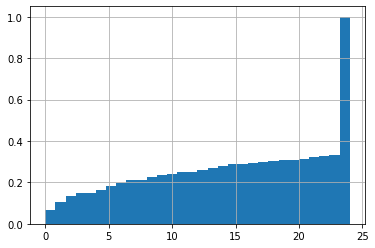

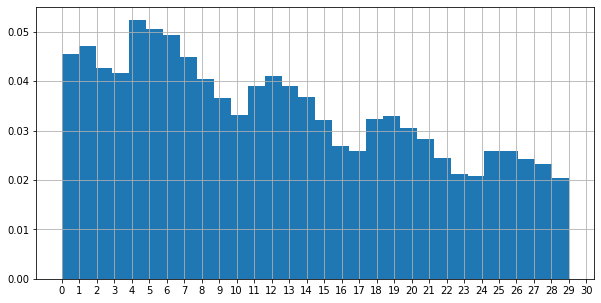

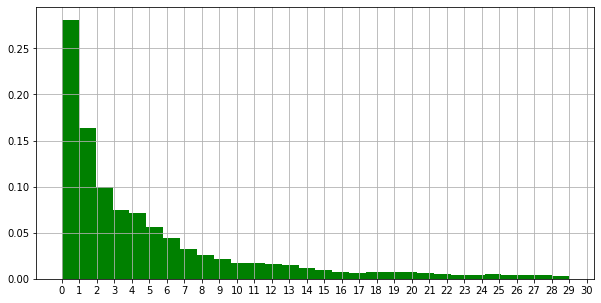

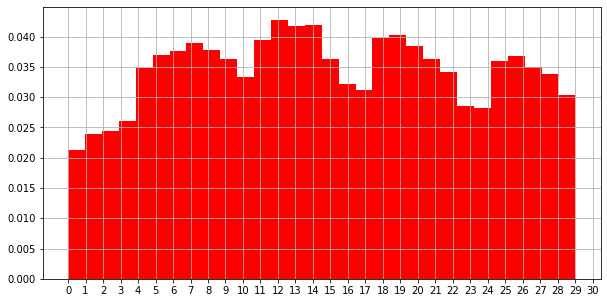

In [145]:

#print(np.histogram(df['target'],bins=30,range=(0,30))[0])

print(df['days_no_sold'].value_counts())

print(df['days_no_sold'].hist(density=True,cumulative=True,bins=30))
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(df[df['days_no_sold']>0]['target'],bins=30,density=True)
ax.set_xticks(np.arange(31))
ax.grid()
fig.show()

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(df[df['days_no_sold'].between(0,5)]['target'],bins=30,color='green',density=True)
ax.set_xticks(np.arange(31))
ax.grid()
fig.show()


fig, ax = plt.subplots(figsize=(10,5))
ax.hist(df[df['days_inactive']>0]['target'],bins=30,color='red',density=True)
ax.set_xticks(np.arange(31))
ax.grid()
fig.show()

100%|██████████| 1443/1443 [00:08<00:00, 169.31it/s]

tensor(3.5925)


In [25]:
from tqdm import tqdm,trange
from torch.nn import MSELoss
import numpy as np

#model = ChallengeModel().cuda()
#model.load_state_dict(torch.load('./model/LSTM2/model_25193.pt'))


torch.cuda.empty_cache()
L = []
model.eval()
for i,sample in tqdm(enumerate(dataloaders['test']),
                         total=len(dataloaders['test']) ):
    out = model(sample)
    L.append(out.clone().detach().cpu())
L = torch.cat(L,axis=0)
L = L.cpu().numpy()
L = np.round(L,decimals=3)
print(L.shape)
print(L)    

100%|██████████| 4309/4309 [00:15<00:00, 282.67it/s]


(551472, 30)
[[0.001 0.004 0.009 ... 0.026 0.018 0.015]
 [0.001 0.003 0.006 ... 0.034 0.023 0.019]
 [0.084 0.174 0.135 ... 0.004 0.002 0.002]
 ...
 [0.002 0.005 0.005 ... 0.057 0.063 0.043]
 [0.029 0.034 0.04  ... 0.021 0.01  0.01 ]
 [0.002 0.003 0.003 ... 0.06  0.084 0.051]]


In [26]:
model.NAME='LSTM3'
import pandas as pd
out_df = pd.DataFrame(L)
display(out_df)
out_df.to_csv(f'./{model.NAME}_1.csv.gz',index=False,header=False,compression='gzip')

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.001,0.004,0.009,0.015,0.031,0.038,0.051,0.045,0.065,0.041,...,0.039,0.037,0.026,0.023,0.023,0.025,0.021,0.026,0.018,0.015
1,0.001,0.003,0.006,0.013,0.023,0.026,0.041,0.036,0.050,0.035,...,0.046,0.046,0.030,0.026,0.028,0.036,0.027,0.034,0.023,0.019
2,0.084,0.174,0.135,0.127,0.099,0.086,0.069,0.036,0.030,0.022,...,0.004,0.004,0.004,0.004,0.004,0.005,0.003,0.004,0.002,0.002
3,0.013,0.029,0.046,0.057,0.098,0.116,0.111,0.079,0.082,0.032,...,0.009,0.009,0.007,0.008,0.006,0.006,0.004,0.009,0.003,0.004
4,0.001,0.005,0.008,0.014,0.021,0.026,0.040,0.050,0.035,0.048,...,0.037,0.035,0.029,0.022,0.022,0.033,0.025,0.038,0.014,0.021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551467,0.002,0.003,0.003,0.007,0.009,0.010,0.010,0.013,0.012,0.019,...,0.060,0.057,0.054,0.051,0.041,0.071,0.068,0.061,0.089,0.054
551468,0.003,0.005,0.005,0.008,0.013,0.011,0.011,0.016,0.014,0.024,...,0.066,0.051,0.055,0.048,0.035,0.058,0.068,0.058,0.073,0.049
551469,0.002,0.005,0.005,0.010,0.014,0.015,0.014,0.017,0.019,0.026,...,0.062,0.055,0.050,0.046,0.036,0.056,0.051,0.057,0.063,0.043
551470,0.029,0.034,0.040,0.045,0.069,0.049,0.052,0.065,0.046,0.064,...,0.029,0.018,0.020,0.016,0.010,0.015,0.011,0.021,0.010,0.010


<ipython-input-19-c1b598cd2321>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-19-c1b598cd2321>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


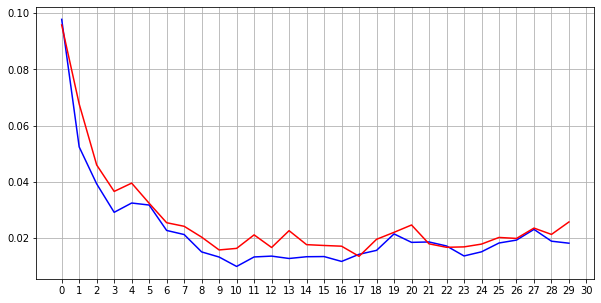

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
ax.set_xticks(np.arange(31))
ax.grid()
fig.show()
df1 = pd.read_csv('./LSTM1.csv.gz',header=None)
plt.plot(np.arange(30),np.std(df.values,axis=0),c='blue')
df = pd.read_csv('./LSTM2.csv.gz',header=None)
ax.plot(np.arange(30),np.std(df.values,axis=0),c='red')
fig.show()

In [9]:
import pandas as pd
df1 = pd.read_csv('./LSTM1.csv.gz',header=None)
display(df1)
df2 = pd.read_csv('./LSTM2.csv.gz',header=None)
df = pd.DataFrame(0.5*(df1.values+df2.values))
df.to_csv(f'./LSTM_1+2.csv.gz',index=False,header=False,compression='gzip')

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.005,0.006,0.011,0.015,0.026,0.037,0.046,0.051,0.041,0.045,...,0.037,0.034,0.027,0.024,0.024,0.024,0.022,0.023,0.020,0.016
1,0.005,0.009,0.015,0.021,0.036,0.054,0.060,0.068,0.051,0.053,...,0.031,0.026,0.020,0.018,0.017,0.017,0.016,0.013,0.013,0.010
2,0.214,0.186,0.155,0.102,0.093,0.053,0.042,0.024,0.018,0.017,...,0.004,0.002,0.002,0.003,0.001,0.001,0.002,0.001,0.001,0.001
3,0.042,0.046,0.064,0.062,0.088,0.096,0.075,0.062,0.056,0.046,...,0.015,0.012,0.009,0.010,0.007,0.009,0.008,0.005,0.007,0.005
4,0.006,0.006,0.010,0.012,0.021,0.026,0.035,0.035,0.036,0.037,...,0.042,0.039,0.036,0.032,0.029,0.033,0.031,0.034,0.028,0.027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551467,0.006,0.005,0.007,0.010,0.013,0.014,0.022,0.021,0.027,0.024,...,0.048,0.046,0.045,0.043,0.042,0.048,0.049,0.054,0.047,0.047
551468,0.006,0.005,0.007,0.010,0.014,0.014,0.022,0.021,0.027,0.024,...,0.047,0.045,0.045,0.043,0.042,0.048,0.049,0.054,0.048,0.047
551469,0.007,0.007,0.008,0.012,0.016,0.016,0.025,0.023,0.029,0.026,...,0.045,0.044,0.043,0.041,0.041,0.046,0.046,0.050,0.045,0.044
551470,0.016,0.017,0.021,0.023,0.030,0.032,0.040,0.038,0.037,0.037,...,0.035,0.035,0.032,0.032,0.032,0.032,0.031,0.031,0.029,0.027


<ipython-input-5-4140870242f4>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


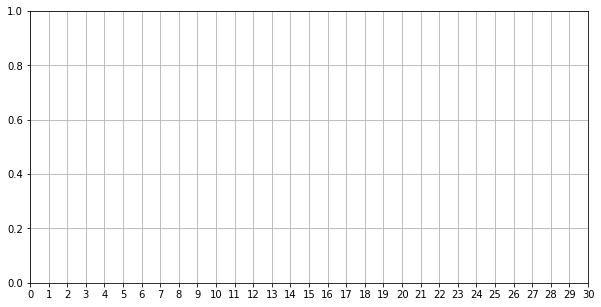

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df1 = pd.read_csv('./LSTM1.csv.gz',header=None)

skus = datasets['test'].skus.copy()

<ipython-input-56-10eb185438e3>:74: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


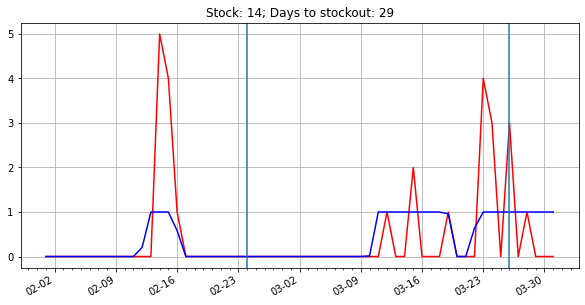

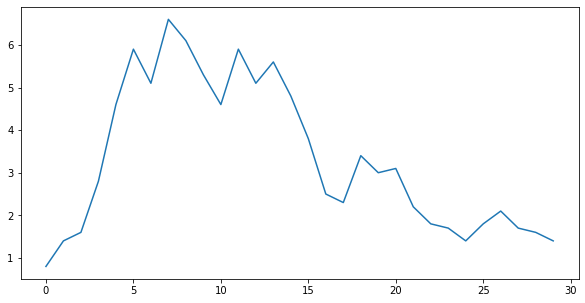

In [56]:
sku = skus[23]

df2 = pd.read_csv('./LSTM2.csv.gz',header=None)
def sep_train_val(df,validation_mode=0):
    train_init = pd.to_datetime('2021-02-01T00:00:00.000000000')
    val_init = pd.to_datetime('2021-02-25T00:00:00.000000000')

    is_train =  (pd.to_datetime(df['date']) - train_init).dt.days < 24
    is_val = ~is_train & (( pd.to_datetime(df['date']) - val_init ).dt.days < 30)
    train = df[is_train].copy()
    val = df[is_val].copy()
    val['days_passed'] =  (pd.to_datetime(df['date']) - val_init).dt.days
    val['cumsum'] = val['sold_quantity'].cumsum()

    if (train.shape[0]==0) or (not val.shape[0] == 30) or (val['cumsum'].values[0] ==val['cumsum'].values[-1]):
        """
            Useless sample for validation. Return some other (hopefully good sample instead)
        """
        raise ""

    if df['stock'].values[0] < 0 or validation_mode == 0:
        """ We take the last day with nonzero sold quantity.
            Then, the stock is the amount of items sold from the 
            beginning of the validation month till this day.
        """
        days_to_stockout = int(val[val['sold_quantity']>0]\
                            ['days_passed'].values[-1])
        stock = (val['cumsum'].values[-1] - val['cumsum'].values[0])
    elif validation_mode == 1:
        """ The stock is the same as given in the test data. If our
            task in the test data is to predict how long till x units of
            product y are sold, then we count how many days in the validation
            month it took to produce that amount.
        """
        stock = df['stock'].values[0]
        if val[val['cumsum']>=stock].shape[0] == 0:
            raise ''

        days_to_stockout = int(val[val['cumsum']>=stock]\
                            ['days_passed'].values[0])
    
    
    return train, val, stock, days_to_stockout

df_sku = df[df['sku']==sku]
df_sku_train, df_sku_val,stock, days_to_stockout = sep_train_val(df_sku)


import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(10,5))

# Major ticks every 6 months.
fmt_half_year = mdates.DayLocator(interval=7)
ax.xaxis.set_major_locator(fmt_half_year)

# Minor ticks every month.
fmt_month = mdates.DayLocator(interval=1)
ax.xaxis.set_minor_locator(fmt_month)

# Text in the x axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Format the coords message box, i.e. the numbers displayed as the cursor moves
# across the axes within the interactive GUI.
ax.grid(True)
fig.autofmt_xdate()
#ax.grid()
ax.plot(df_sku['date'],df_sku['sold_quantity'],c='red')

ax.plot(df_sku['date'],df_sku['minutes_active'],c='blue')
ax.axvline(df_sku_train['date'].values[-1])
ax.axvline(df_sku_val[df_sku_val['cumsum']>=stock]['date'].values[0])
ax.set_title(f"Stock: {stock}; Days to stockout: {days_to_stockout}")
fig.show()

df2['sku'] = skus 

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(30),100*np.round(df2[df2['sku']==sku].values[0,:-1],decimals=3) )
